# Daily Price Range (DPR)

## In the following blocks of code i will explain how I backtested DPR strategy on BTC/USD 

Insights will be printed out below relevant code blocks

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import matplotlib.ticker as mticker

# import csv file with timestamp in unix, daily closes
df = pd.read_csv('BITSTAMP_BTCUSD, 1D 2.csv')
df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))
df = df[(df['time'] >= datetime.fromisoformat('2019-01-01')) & (df['time'] <= datetime.fromisoformat('2023-05-31'))]

# take columns I am interested in
df = df[['time', 'open', 'high', 'low', 'close']]

# make a separate set of columns for OHLC data, shifted to yesterday's value (has to be done in order to conduct proper analysis)
df['prev_open'] = df['open'].shift(1)
df['prev_high'] = df['high'].shift(1)
df['prev_low'] = df['low'].shift(1)
df['prev_close'] = df['close'].shift(1)

# calculate daily pivot price
# dpp and other values for day 'n' are calculated with data from day 'n-1' to simulate data you have in real time trading
df['dpp'] = df[['prev_high','prev_low','prev_close']].sum(axis=1) / 3

# calculate second number
df['snr'] = df[['prev_high','prev_low']].sum(axis=1) / 2

# calculate abs dpr diff
df['dpr_dif'] = (df['dpp'] - df['snr']).abs()

df['dpr_low'] = df['dpp'] - df['dpr_dif']
df['dpr_high'] = df['dpp'] + df['dpr_dif']

# CALCULATIONS FOR 3DPR
# find 3 day low and high for each period
df['3d_low'] = df['prev_low'].rolling(window = 3).min()
df['3d_high'] = df['prev_high'].rolling(window = 3).max()

#  calculate 3 day pivot price
df['3dpp'] = df[['3d_high','3d_low','prev_close']].sum(axis=1) / 3

# calculate second number for 3dpr
df['snr_3dpr'] = df[['3d_high','3d_low']].sum(axis=1) / 2

# calculate abs dpr diff
df['3dpr_dif'] = (df['3dpp'] - df['snr_3dpr']).abs()

df['3dpr_low'] = df['3dpp'] - df['3dpr_dif']
df['3dpr_high'] = df['3dpp'] + df['3dpr_dif']



# make function 1, in which I check if today's open is above DPR
# if open is above DPR high i look for longs
# if open is below dpr low I look for shorts

def fn1(df):
    if ( df['open'] >= df['dpr_high'] ):
        return 'look_for_longs'
    elif (df['open'] <= df['dpr_low']):
        return 'look_for_shorts'

# add column trade opportunity with results from fn1
df['trade_opportunity'] = df.apply(fn1, axis = 1)

# function describes different trade types
def fn2(df):
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] > df['dpr_low']):
        return 'perfect_long'
# perfect long not the best name, it means that long didn't get stoped out, it can be a profitable long or not
# perfect long is profitable when daily close is above DPR high and negative when close is between DPR low and DPR high 
    if (df['trade_opportunity'] == 'look_for_longs' and df['low']  <= df['dpr_low']):
        return 'stop_out_long'
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] <= df['dpr_high'] and df['high'] > df['dpr_low']):
        return 'perfect_short'
# same definition as for long but the other way around
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_high'] ):
        return 'stop_out_short'
    
df['ls'] = df.apply(fn2, axis = 1)

df_print = df[['open','low', 'high', 'close', 'dpp','dpr_low','dpr_high', '3dpp','3dpr_low','3dpr_high', 'trade_opportunity', 'ls']]
#df_print.tail(5)

In [21]:

long_that_did_not_get_stopped = (df[df['ls'] == 'perfect_long'].count()['ls'])
stop_out_long_count = (df[df['ls'] == 'stop_out_long'].count()['ls'])
short_that_did_not_get_stopped = (df[df['ls'] == 'perfect_short'].count()['ls'])
stop_out_short_count = (df[df['ls'] == 'stop_out_short'].count()['ls'])

print(f'Triggers for long: If price is above DPR a buy order is set on DPR high and stop-loss is set on DPR low,\
the oposite \n\
is done for shorts. \n\n\
Count of longs that did not get stoped is: {long_that_did_not_get_stopped}\n\
Count of longs that got stoped is: {stop_out_long_count}\n\
Count of shorts that did not get stoped is: {short_that_did_not_get_stopped}\n\
Count of shorts that got stoped is: {stop_out_short_count}\n\n\
So we can se that a lot of trades are taken with this condtion, in the next blocks we will try to limit them')

Triggers for long: If price is above DPR a buy order is set on DPR high and stop-loss is set on DPR low,the oposite 
is done for shorts. 

Count of longs that did not get stoped is: 202
Count of longs that got stoped is: 590
Count of shorts that did not get stoped is: 141
Count of shorts that got stoped is: 491

So we can se that a lot of trades are taken with this condtion, in the next blocks we will try to limit them


In [23]:
# function calculates pct gain on trades
def fn4(df):
# the first condition checks if the trade was filled, so that means low has to be <= to dpr high where we have orders
# second part checks if low was above dpr low where we have stop orders
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] >= df['dpr_low']) :
        return ((df['close'] - df['dpr_high']) / df['dpr_high']) *100
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] < df['dpr_low']) :
        return ((df['dpr_low'] - df['dpr_high']) / df['dpr_high'] ) *100
# longs - vice versa
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] <= df['dpr_high']) :
        return (-((df['close'] - df['dpr_low']) / df['dpr_low'])) *100
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] > df['dpr_high']) :
        return (-(df['dpr_high'] - df['dpr_low']) / df['dpr_low'] ) *100

df['pct_on_trade'] = df.apply(fn4, axis = 1)

df_tbl1 = df
#df_tbl1[['time','open','high','low','close', 'dpr_high','dpr_low','pct_on_trade','trade_opportunity']].tail(5)

This is visualization of May-23 trades

All of the trades are closed at close price (light green line)

Triangels stand for profitable longs and shorts, both are closed on the daily close - light green line 
 
x - are stoped out trades
 
Daily lows and highs are are added to give you idea about where in the range the trades occured


<Figure size 640x480 with 0 Axes>

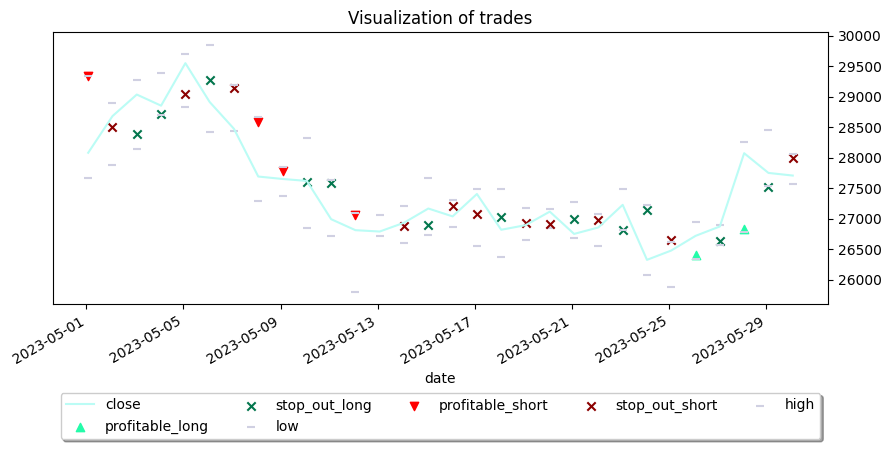

In [24]:
# function 5, checks for profitable longs and asigns entry to it
def fn5(df):
    if ((df['ls'] == 'perfect_long')& (df['close'] > df['dpr_high'])) :
        return df['dpr_high']

# function 6, checks for losses, stop outs and trades that closed within DPR (so close is below DPR high but not below dpr low)
def fn6(df):
    if ((df['ls'] == 'stop_out_long') | ((df['ls'] == 'perfect_long') & (df['close'] <= df['dpr_high']))):
        return df['dpr_low']

# function 7, checks for profitable shorts
def fn7(df):
    if ((df['ls'] == 'perfect_short') & (df['close'] < df['dpr_low'])):
        return df['dpr_low']
    

# function 8, checks for losses, stop outs and trades that closed within DPR (so close is above DPR low but not above dpr high)
def fn8(df):
    if ((df['ls'] == 'stop_out_short') | ((df['ls'] == 'perfect_short') & (df['close'] > df['dpr_low']))):
        return df['dpr_high']

        
df['in_money_long_entry'] = df.apply(fn5, axis = 1)
df['sl_triggered_long_sl'] = df.apply(fn6, axis = 1)
df['in_money_short_entry'] = df.apply(fn7, axis = 1)
df['sl_triggered_short_sl'] = df.apply(fn8, axis = 1)
        
df_plot = df
df_plot = df_plot[(df_plot['time'] >= datetime.fromisoformat('2023-05-01')) & (df_plot['time'] <= datetime.fromisoformat('2023-05-31'))]
 
    
x = df_plot['time']
y1 = df_plot['close']

y2 = df_plot['in_money_long_entry']
y3 = df_plot['sl_triggered_long_sl']
y4 = df_plot['low']
y5 = df_plot['in_money_short_entry']
y6 = df_plot['sl_triggered_short_sl']
y7 = df_plot['high']



fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(x, y1, label='close', color = (187/255, 252/255, 226/235))
ax.scatter(x, y2, label='profitable_long', marker = "^", color =(36/255, 251/255, 169/255))
ax.scatter(x, y3, label='stop_out_long',  marker = "x", color =(3/255, 118/255, 71/235)) 
#ax.scatter(x, y4, label='low',  marker = "_", color =(208/255, 208/255, 208/235))  

ax.scatter(x, y4, label='low',  marker = "_", color =(208/255, 208/255, 208/235))  

ax.scatter(x, y5, label='profitable_short', marker = "v", color =(255/255, 0/255, 0/255))
ax.scatter(x, y6, label='stop_out_short',  marker = "x", color =(139/255, 0/255, 0/235)) 
ax.scatter(x, y7, label='high',  marker = "_", color =(208/255, 208/255, 208/235)) 

ax.set_xlabel('date')
ax.xaxis_date()

fig.autofmt_xdate()

ticks_loc = ax.get_yticks().tolist();

#x.set_yticklabels([f'{x:.0f}%' for x in ticks_loc]);
ax.yaxis.tick_right()
#ax.legend()
ax.set_title('Visualization of trades')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5)

print('This is visualization of May-23 trades\n' '\nAll of the trades are closed at close price (light green line)' \
      '\n' '\nTriangels stand for profitable longs and shorts, both are closed on the daily close - light green line '\
      '\n ' '\nx - are stoped out trades'\
      '\n ' '\nDaily lows and highs are are added to give you idea about where in the range the trades occured')

In [25]:
# check how much we'd make
investment = x = 1000

df['running_sum'] = (1 + (df['pct_on_trade'] /100)).cumprod() * x

df['pct_change_hodl'] = df['close'].pct_change()
df['running_sum_hodl'] = (1 + (df['pct_change_hodl'])).cumprod() * x

#df.head()


Text(0.5, 1.0, 'Portfolio performance')

<Figure size 640x480 with 0 Axes>

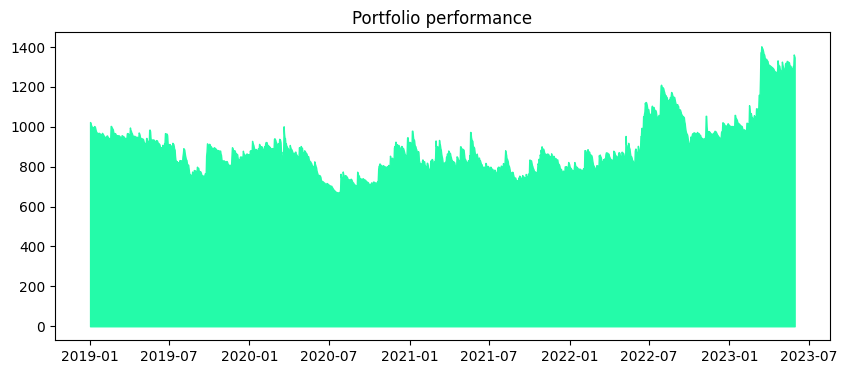

In [26]:
df_plot2 = df
# df_plot2 = df_plot2[(df_plot2['time'] >= datetime.fromisoformat('2021-01-01')) & (df_plot2['time'] <= datetime.fromisoformat('2023-05-31'))]
 
    
x = df_plot2['time']
y1 = df_plot2['running_sum'].ffill()


fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='close', color = (36/255, 251/255, 169/255))
ax.set_title('Portfolio performance')

Text(0.5, 1.0, 'Portfolio performance vs hodl')

<Figure size 640x480 with 0 Axes>

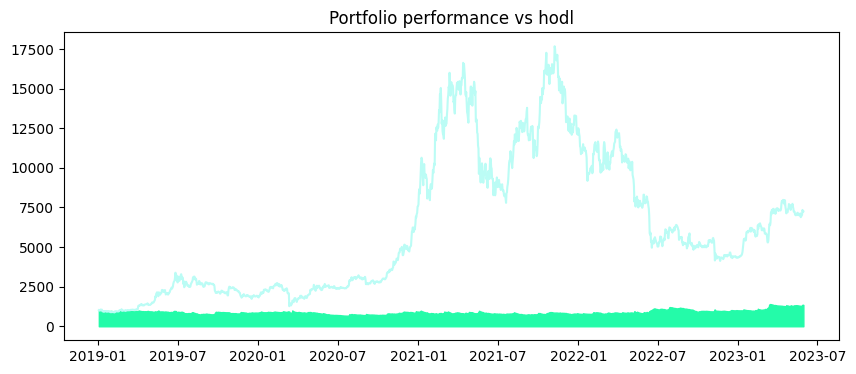

In [27]:
# this is how it looks vs hodl

    
x = df_plot2['time']
y1 = df_plot2['running_sum'].ffill()
y2 = df_plot2['running_sum_hodl'].ffill()

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='close', color = (36/255, 251/255, 169/255))
ax.plot(x, y2, label='close', color = (187/255, 252/255, 226/235))
ax.set_title('Portfolio performance vs hodl')

## Let's dig into some stats that take into account all of the taken trades

In [29]:
average_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].mean().round(2)
average_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].mean().round(2)

max_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].max().round(2)
max_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].min().round(2)

count_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].count()
count_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].count()


print(count_gain,' Count of profitable trades')
print(average_gain,' average pct gain')
print(max_gain,' max pct gain')
print(' ')
print(count_loss,' Count of losing trades')
print(average_loss,' average pct loss')
print(max_loss,' max pct loss')


284  Count of profitable trades
2.85  average pct gain
15.58  max pct gain
 
1139  Count of losing trades
-0.66  average pct loss
-5.05  max pct loss


## Let's see ranges, what was the loosest and thighest range

In [31]:
df['dpr_range'] = df['dpr_high'] / df['dpr_low'] - 1 
loosest_range = df.loc[df['dpr_range'] > 0, 'dpr_range'].max().round(2)
# 0.19 apparently
date = df.loc[df['dpr_range'] > 0.1, ['time']]

widest_range = df['dpr_range'].max().round(4)
tightest_range = df['dpr_range'].min()
avg_range = df['dpr_range'].mean().round(4)

#print('multiply by 100 if you want pct')
print('')
print('loosest range: ',loosest_range)
print('tightest_range: ',tightest_range)
print('avg_range: ',avg_range)
print('')
# big range
# print('date of 19 pct range')
# print(' ')
# print(date)


loosest range:  0.19
tightest_range:  0.0
avg_range:  0.009



## Now we will check what type of ranges are a good trigger for profitable trade

As we will see in the following blocks 80% of the total trades taken under current condidtion happen in the thight range < 0,4%, as provided in the following two blocks of code. We can see that majority of the profitable trades occur in the thight range, but sadly majority of the losses as well. The good news is that a lot of highly profitable trades (above +5,5% occur in the thight range, where as losses go only as low as the range itself - 0,4%)

In [50]:
# check performace of trades in different ranges
import seaborn as sns


df['pct_on_trade1'] = df['pct_on_trade']
# function x, checks for profitable trades
def fnx(df):
    if pd.isnull(df['pct_on_trade1']) == False :
        return 1.0
    else:
        return 0

# fn y
def fny(df):
    if df['dpr_range'] <= 0:
        return 0
    else:
        return df['dpr_range']

df['all_trades'] = df.apply(fnx, axis = 1)
df['all_trades'].astype(float)
df['dpr_range1'] = df.apply(fny, axis = 1).abs()

num_bins = 20  # Number of bins you want

df['range_bins'] = pd.cut(df['dpr_range1'], bins=num_bins)

df['average_value'] = df.groupby('range_bins')['dpr_range'].transform('mean')



df_sum = df.groupby('average_value')['all_trades'].sum()

print(f'The left column represents avg width of the range in which trade entry occured'\
      '\n''\nRight column represents count of trades that occured in the range'\
      '\n''\ni.e. 960 of total trades occured in 0,41% tight range')


df_sum

The left column represents avg width of the range in which trade entry occured

Right column represents count of trades that occured in the range

i.e. 960 of total trades occured in 0,41% tight range


average_value
0.004061    960.0
0.013573    320.0
0.023002     99.0
0.033614     26.0
0.042003     12.0
0.052945      4.0
0.063470      1.0
0.095195      1.0
0.190772      1.0
Name: all_trades, dtype: float64

In [53]:
# check performace of trades in different ranges
import seaborn as sns


df['pct_on_trade1'] = df['pct_on_trade'].dropna()
# function x, checks for profitable trades
def fnx(df):
    if df['pct_on_trade1'] > 0.5:
        return 1.0
    else:
        return 0

# fn y
def fny(df):
    if df['dpr_range'] <= 0:
        return 0
    else:
        return df['dpr_range']

df['positive_trades'] = df.apply(fnx, axis = 1)
df['positive_trades'].astype(float)
df['dpr_range1'] = df.apply(fny, axis = 1).abs()

num_bins = 20  # Number of bins you want

df['range_bins'] = pd.cut(df['dpr_range1'], bins=num_bins)

df['average_value'] = df.groupby('range_bins')['dpr_range'].transform('mean')



df_sum = df.groupby('average_value')['positive_trades'].sum()

print('The left column represents avg width of the range in which trade entry occured'\
      '\n''\nRight column represents count of trades that made +0.5% of profit'\
      '\n''\ni.e. 97 trades that profited >0.5% occured in 0,41% tight range')


df_sum

The left column represents avg width of the range in which trade entry occured

Right column represents count of trades that made +0.5% of profit

i.e. 97 trades that profited >0.5% occured in 0,41% tight range


average_value
0.004061     97.0
0.013573    104.0
0.023002     30.0
0.033614      8.0
0.042003      5.0
0.052945      2.0
0.063470      1.0
0.095195      0.0
0.190772      0.0
Name: positive_trades, dtype: float64

In [54]:
# check performace of trades in different ranges
import seaborn as sns


df['pct_on_trade1'] = df['pct_on_trade'].dropna()
# function x, checks for profitable trades
def fnx(df):
    if df['pct_on_trade1'] > 5.5:
        return 1.0
    else:
        return 0

# fn y
def fny(df):
    if df['dpr_range'] <= 0:
        return 0
    else:
        return df['dpr_range']

df['positive_trades1'] = df.apply(fnx, axis = 1)
df['positive_trades1'].astype(float)
df['dpr_range1'] = df.apply(fny, axis = 1).abs()

num_bins = 20  # Number of bins you want
df['range_bins'] = pd.cut(df['dpr_range1'], bins=num_bins)
df['average_value'] = df.groupby('range_bins')['dpr_range'].transform('mean')
df_sum1 = df.groupby('average_value')['positive_trades1'].sum()

print('The left column represents avg width of the range in which trade entry occured'\
      '\n''\nRight column represents count of trades that made +5.5% of profit'\
      '\n''\ni.e. 20 trades that profited >5.5% occured in 0,41% tight range')
df_sum1

The left column represents avg width of the range in which trade entry occured

Right column represents count of trades that made +5.5% of profit

i.e. 20 trades that profited >5.5% occured in 0,41% tight range


average_value
0.004061    20.0
0.013573    15.0
0.023002     4.0
0.033614     1.0
0.042003     0.0
0.052945     0.0
0.063470     0.0
0.095195     0.0
0.190772     0.0
Name: positive_trades1, dtype: float64

In [55]:
# check performace of trades in different ranges
import seaborn as sns


df['pct_on_trade1'] = df['pct_on_trade'].dropna()
# function z, checks for profitable trades
def fnz(df):
    if df['pct_on_trade1'] < 0.0:
        return 1.0
    else:
        return 0

# fn y
def fny(df):
    if df['dpr_range'] <= 0:
        return 0
    else:
        return df['dpr_range']

df['neg_trades'] = df.apply(fnz, axis = 1)
df['neg_trades'].astype(float)
df['dpr_range1'] = df.apply(fny, axis = 1).abs()

num_bins = 20  # Number of bins you want

df['range_bins'] = pd.cut(df['dpr_range1'], bins=num_bins)

df['average_value'] = df.groupby('range_bins')['dpr_range'].transform('mean')


df_sum3 = df.groupby('average_value')['positive_trades'].sum()

print('The left column represents avg width of the range in which trade entry occured'\
      '\n''\nRight column represents count of trades that made loss'\
      '\n''\ni.e. 80% of losses occur in thtightest range')


df_sum3

The left column represents avg width of the range in which trade entry occured

Right column represents count of trades that made loss

i.e. 80% of losses occur in thtightest range


average_value
0.004061     97.0
0.013573    104.0
0.023002     30.0
0.033614      8.0
0.042003      5.0
0.052945      2.0
0.063470      1.0
0.095195      0.0
0.190772      0.0
Name: positive_trades, dtype: float64

In [65]:
# function calculates pct gain on trades in tight ranges

def fn11(df):
    if (df['dpr_range'] <= 0.015):
        return df['pct_on_trade']
    else:
        return 0

df['pct_on_trade_range'] = df.apply(fn11, axis = 1)


investment = x = 1000

df['running_sum_new'] = (1 + (df['pct_on_trade_range'] /100)).cumprod() * x

df_print11 = df

#df_print11.tail()


## The following chart shows us that strat that only trades on thight ranges outperforms strat that trades on all ranges (mainly due to the fact it takes less trades and mitigates loss per trade)

For tigt range I choose first two buckets, so range is up to 1,5% loose. Just first bucket does not provide good results.

Text(0.5, 1.0, 'Strat with tighter ranges vs wo range tightnes limitation')

<Figure size 640x480 with 0 Axes>

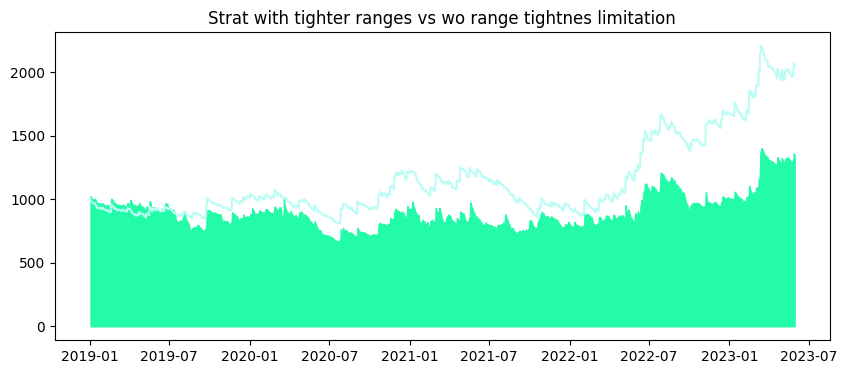

In [66]:
x = df_print11['time']
y1 = df_print11['running_sum'].ffill()
y2 = df_print11['running_sum_new'].ffill()

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='close', color = (36/255, 251/255, 169/255))
ax.plot(x, y2, label='close', color = (187/255, 252/255, 226/235))
ax.set_title('Strat with tighter ranges vs wo range tightnes limitation')

In [68]:
# function calculates pct gain on trades
def fn12(df):
# the first condition checks if the trade was filled, so that means low has to be <= to dpr high where we have orders
# second part checks if low was above dpr low where we have stop orders
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] >= df['dpr_low']*0.985) :
        return ((df['close'] - df['dpr_high']) / df['dpr_high']) *100
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] < df['dpr_low']*0.985) :
        return ((df['dpr_low']*0.985 - df['dpr_high']) / df['dpr_high'] ) *100
# longs - vice versa
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] <= df['dpr_high']) :
        return (-((df['close'] - df['dpr_low']) / df['dpr_low'])) *100
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] > df['dpr_high']) :
        return (-(df['dpr_high'] - df['dpr_low']) / df['dpr_low'] ) *100

df['pct_on_trade_sl_below_range'] = df.apply(fn12, axis = 1)

df_tbl2 = df
#df_tbl2[['time','open','high','low','close', 'dpr_high','dpr_low','pct_on_trade','pct_on_trade_sl_below_range']].tail(20)

In [70]:
# function calculates pct gain on trades in tight ranges

def fn14(df):
    if (df['dpr_range'] <= 0.005 ):
        return df['pct_on_trade_sl_below_range']
    else:
        return 0

df['pct_on_trade_sl_below_range_range'] = df.apply(fn14, axis = 1)


investment = x = 1000

df['running_sum_new_2'] = (1 + (df['pct_on_trade_sl_below_range_range'] /100)).cumprod() * x

df_print14 = df

#df_print14[['time','open','high','low','close','dpr_range', 'pct_on_trade','running_sum','running_sum_new','pct_on_trade_sl_below_range_range','running_sum_new_2']].tail(50)

# So thight ranges seem to be COOL, but they stop out many trades that would turn profitable if the range LOW was not hit that day

## My idea was to only trade very thight ranges (below 0,5%), but add a stop loss below the DPR low, so the trade does not get taken out as quickly... but thight ranges below 1,5% still provide better return

<Figure size 640x480 with 0 Axes>

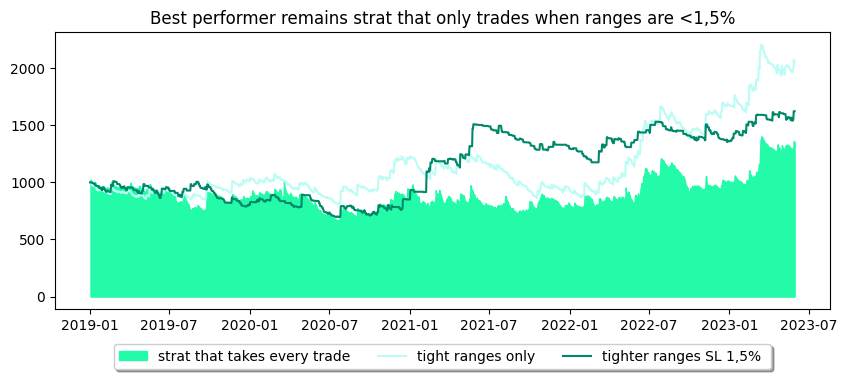

In [93]:
x = df_plot2['time']
y1 = df_plot2['running_sum'].ffill()
y2 = df_plot2['running_sum_new'].ffill()
y3 = df_plot2['running_sum_new_2'].ffill()

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='strat that takes every trade', color = (36/255, 251/255, 169/255))
ax.plot(x, y2, label='tight ranges only', color = (187/255, 252/255, 226/235))
ax.plot(x, y3, label='tighter ranges SL 1,5% ', color = (0/255, 136/255, 106/255))

ax.set_title('Best performer remains strat that only trades when ranges are <1,5%')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=10)

In [73]:
# function calculates pct gain on trades
def fn15(df):
# the first condition checks if the trade was filled, so that means low has to be <= to dpr high where we have orders
# second part checks if low was above dpr low where we have stop orders
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['3dpr_high'] and df['low'] >= df['3dpr_low']) :
        return ((df['close'] - df['dpr_high']) / df['dpr_high']) *100
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['3dpr_high'] and df['low'] < df['3dpr_low']) :
        return ((df['3dpr_low'] - df['3dpr_high']) / df['3dpr_high'] ) *100
# longs - vice versa
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['3dpr_low'] and df['high'] <= df['3dpr_high']) :
        return (-((df['close'] - df['3dpr_low']) / df['3dpr_low'])) *100
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['3dpr_low'] and df['high'] > df['3dpr_high']) :
        return (-(df['3dpr_high'] - df['3dpr_low']) / df['dpr_low'] ) *100

df['pct_on_trade_3dpr'] = df.apply(fn15, axis = 1)

df_tbl5 = df
#df_tbl5[['time','open','high','low','close', 'dpr_high','dpr_low','pct_on_trade','pct_on_trade_3dpr']].tail(20)

In [75]:
investment = x = 1000
df['running_sum_3dpr'] = (1 + (df['pct_on_trade_3dpr'] /100)).cumprod() * x
df_tbl6 = df
#df_tbl6[['time','open','high','low','close', 'dpr_high','dpr_low','pct_on_trade','pct_on_trade_3dpr','running_sum_3dpr']].tail(20)

In [77]:
# function calculates pct gain on trades
def fn18(df):
# the first condition checks if the trade was filled, so that means low has to be <= to dpr high where we have orders
# second part checks if low was above dpr low where we have stop orders
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] >= df['dpr_low']
       and df['3dpp'] <= df['dpp']
       ) :
        return ((df['close'] - df['dpr_high']) / df['dpr_high']) *100
    if (df['trade_opportunity'] == 'look_for_longs' and df['low'] <= df['dpr_high'] and df['low'] < df['dpr_low']
       and df['3dpp'] <= df['dpp']) :
        return ((df['dpr_low'] - df['dpr_high']) / df['dpr_high'] ) *100
# longs - vice versa
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] <= df['dpr_high']
       and df['3dpp'] >= df['dpp']) :
        return (-((df['close'] - df['dpr_low']) / df['dpr_low'])) *100
    if (df['trade_opportunity'] == 'look_for_shorts' and df['high'] >= df['dpr_low'] and df['high'] > df['dpr_high']
       and df['3dpp'] >= df['dpp']) :
        return (-(df['dpr_high'] - df['dpr_low']) / df['dpr_low'] ) *100

df['pct_on_trade_new_c'] = df.apply(fn18, axis = 1)

df_tbl1 = df
#df_tbl1[['time','open','high','low','close', 'dpr_high','dpr_low','pct_on_trade','pct_on_trade_new_c']].tail(20)

In [106]:
# check how much we'd make
investment = x = 1000

def fn19(df):
    if (df['dpr_range'] <= 0.015 ):
        return df['pct_on_trade_new_c']
    else:
        return 0

df['pct_on_trade_new_condition'] = df.apply(fn19, axis = 1)
df['running_sum_c'] = (1 + (df['pct_on_trade_new_condition'] /100)).cumprod() * x


df['pct_change_hodl'] = df['close'].pct_change()
df['running_sum_hodl'] = (1 + (df['pct_change_hodl'])).cumprod() * x

df.tail()


,time,open,high,low,close,prev_open,prev_high,prev_low,prev_close,dpp,...,running_sum_new,pct_on_trade_sl_below_range,pct_on_trade_sl_below_range_range,running_sum_new_2,pct_on_trade_3dpr,running_sum_3dpr,pct_on_trade_new_c,pct_on_trade_sl_condition,running_sum_c,pct_on_trade_new_condition
2085,2023-05-26 02:00:00,26486.0,26937.0,26338.0,26718.0,26325.0,26611.0,25878.0,26478.0,26322.333333,...,1986.367027,1.203907,0.000000,1540.351257,-0.499788,6.400994,NaN,0,NaN,NaN
2086,2023-05-27 02:00:00,26716.0,26893.0,26566.0,26872.0,26486.0,26937.0,26338.0,26718.0,26664.333333,...,1982.373132,0.677503,0.677503,1550.787176,0.677503,6.444360,-0.201065,0,2350.844832,-0.201065
2087,2023-05-28 02:00:00,26875.0,28248.0,26785.0,28072.0,26716.0,26893.0,26566.0,26872.0,26777.000000,...,2074.565363,4.650599,4.650599,1622.908073,NaN,NaN,4.650599,0,2460.173205,4.650599
2088,2023-05-29 02:00:00,28071.0,28452.0,27542.0,27749.0,26875.0,28248.0,26785.0,28072.0,27701.666667,...,2064.311626,-0.494260,0.000000,1622.908073,-0.494260,6.412509,-0.494260,0,2448.013564,-0.494260
2089,2023-05-30 02:00:00,27748.0,28054.0,27570.0,27706.0,28071.0,28452.0,27542.0,27749.0,27914.333333,...,2052.048633,-0.594048,0.000000,1622.908073,-0.574885,6.375644,NaN,0,NaN,NaN


# Best strat seems to be Strat that trades thight ranges < 1,5% only when 3dpp is below dpp for longs and above for shorts

<Figure size 640x480 with 0 Axes>

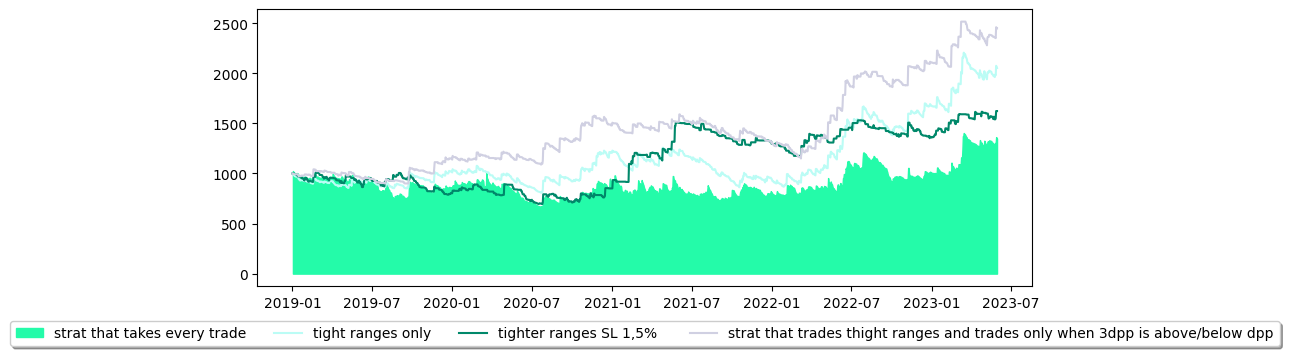

In [107]:
df_plotxy = df
x = df_plotxy['time']
y1 = df_plotxy['running_sum'].ffill()
y2 = df_plotxy['running_sum_new'].ffill()
y3 = df_plotxy['running_sum_new_2'].ffill()
y4 = df_plotxy['running_sum_c'].ffill()

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,4))

ax.fill_between(x, y1, label='strat that takes every trade', color = (36/255, 251/255, 169/255))
ax.plot(x, y2, label='tight ranges only', color = (187/255, 252/255, 226/235))
ax.plot(x, y3, label='tighter ranges SL 1,5% ', color = (0/255, 136/255, 106/255))
ax.plot(x, y4, label='strat that trades thight ranges and trades only when 3dpp is above/below dpp', color = (208/255, 208/255, 208/235))

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=10)

In [122]:
count_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].count()
count_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].count()

average_gain = df.loc[df['pct_on_trade'] > 0, 'pct_on_trade'].mean().round(2)
average_loss = df.loc[df['pct_on_trade'] < 0, 'pct_on_trade'].mean().round(2)

count_gain_strat2 = df.loc[df['pct_on_trade_range'] > 0, 'pct_on_trade_range'].count()
count_loss_strat2 = df.loc[df['pct_on_trade_range'] < 0, 'pct_on_trade_range'].count()

average_gain_strat2 = df.loc[df['pct_on_trade_range'] > 0, 'pct_on_trade_range'].mean().round(2)
average_loss_strat2 = df.loc[df['pct_on_trade_range'] < 0, 'pct_on_trade_range'].mean().round(2)

count_gain_strat3 = df.loc[df['pct_on_trade_sl_below_range_range'] > 0, 'pct_on_trade_sl_below_range_range'].count()
count_loss_strat3 = df.loc[df['pct_on_trade_sl_below_range_range'] < 0, 'pct_on_trade_sl_below_range_range'].count()

average_gain_strat3 = df.loc[df['pct_on_trade_sl_below_range_range'] > 0, 'pct_on_trade_sl_below_range_range'].mean().round(2)
average_loss_strat3 = df.loc[df['pct_on_trade_sl_below_range_range'] < 0, 'pct_on_trade_sl_below_range_range'].mean().round(2)

count_gain_strat4 = df.loc[df['pct_on_trade_new_c'] > 0, 'pct_on_trade_new_c'].count()
count_loss_strat4 = df.loc[df['pct_on_trade_new_c'] < 0, 'pct_on_trade_new_c'].count()

average_gain_strat4 = df.loc[df['pct_on_trade_new_c'] > 0, 'pct_on_trade_new_c'].mean().round(2)
average_loss_strat4 = df.loc[df['pct_on_trade_new_c'] < 0, 'pct_on_trade_new_c'].mean().round(2)



print(f'The strat that takes every trade: \n\
Profitable trades: {count_gain}\n\
Profitable trades: {count_loss}\n\
Average gain: {average_gain}%\n\
Average loss: {average_loss}%\n\n\
The strat that only took trades when ranges were below 1,5% tight: \n\
Profitable trades: {count_gain_strat2}\n\
Profitable trades: {count_loss_strat2}\n\
Average gain: {average_gain_strat2}%\n\
Average loss: {average_loss_strat2}%\n\n\
The strat that only took trades when ranges were below 0,5% tight, and applied SL of 1,5% above/below the range max/min: \n\
Profitable trades: {count_gain_strat3}\n\
Profitable trades: {count_loss_strat3}\n\
Average gain: {average_gain_strat3}%\n\
Average loss: {average_loss_strat3}%\n\n\
The strat that only took trades when ranges were below 1,5% tight and 3dpp was above/below dpp: \n\
Profitable trades: {count_gain_strat4}\n\
Profitable trades: {count_loss_strat4}\n\
Average gain: {average_gain_strat4}%\n\
Average loss: {average_loss_strat4}%')

The strat that takes every trade: 
Profitable trades: 284
Profitable trades: 1139
Average gain: 2.85%
Average loss: -0.66%

The strat that only took trades when ranges were below 1,5% tight: 
Profitable trades: 192
Profitable trades: 986
Average gain: 2.91%
Average loss: -0.48%

The strat that only took trades when ranges were below 0,5% tight, and applied SL of 1,5% above/below the range max/min: 
Profitable trades: 149
Profitable trades: 468
Average gain: 2.57%
Average loss: -0.69%

The strat that only took trades when ranges were below 1,5% tight and 3dpp was above/below dpp: 
Profitable trades: 193
Profitable trades: 671
Average gain: 2.94%
Average loss: -0.69%


## Looks like The strat that only took trades when ranges were below 1,5% tight and 3dpp was above/below dpp performs best